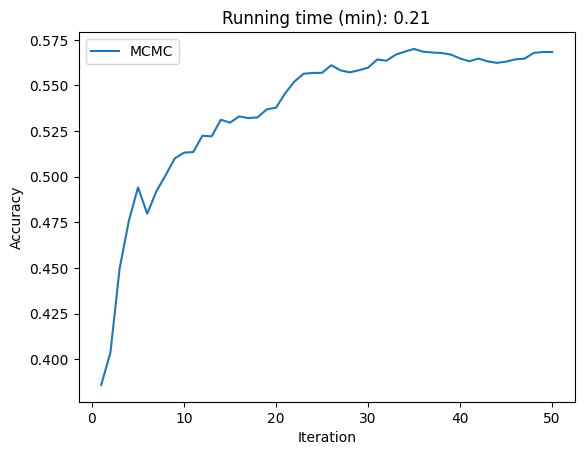

In [1]:
#CPU
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import random
import time

def RRBLUP_gibbs(X, y, σ2_e, σ2_a, nIter):
    p = X.shape[1]  # Number of SNP markers
    a = np.zeros(p, dtype=np.float32)  # Marker effects
    mcmc_a = np.zeros((nIter, p), dtype=np.float32)  # MCMC samples of SNP marker effects
    ycorr = y - np.dot(X, a)  # y corrected for all markers

    for iter in range(nIter):
        λ = σ2_e / σ2_a
        for j in range(p):
            oldAlpha = a[j]
            xj = X[:, j]
            xjtxj = np.dot(xj.T, xj)
            rhs = np.dot(xj, ycorr) + xjtxj * oldAlpha
            lhs = xjtxj + λ
            invLhs = 1.0 / lhs
            a[j] = invLhs * rhs + np.random.randn() * np.sqrt(invLhs * σ2_e).astype(np.float32)
            ycorr += (oldAlpha - a[j]) * xj
        mcmc_a[iter, :] = a
    return mcmc_a

# Load genotype data
X = np.loadtxt("geno_n3534_p10000.txt", delimiter=',').astype(np.float32)
X = X - np.mean(X, axis=0)
Xtrain = X[:3000, :]
Xtest = X[3000:, :]
n, p = X.shape

# Load phenotype data
y_df = pd.read_csv("y.h2.0.3.qtlpct.0.1.rep.1.csv")
y = y_df['y'].values.astype(np.float32)
bv = y_df['bv'].values.astype(np.float32)
ytrain = y[:3000]
bv_test = bv[3000:]

# Set experiment parameters
qtl_pct = 0.1
h2 = 0.3
n_qtl = int(p * qtl_pct)
σ2_e = np.float32(1 - h2)
σ2_a = np.float32(h2 / n_qtl)
nIter = 50

# Set random seed for reproducibility
np.random.seed(123)  # Changed to np.random.seed for consistency with numpy

# Run the RRBLUP Gibbs sampler
start_time = time.time()
mcmc_a = RRBLUP_gibbs(Xtrain, ytrain, σ2_e, σ2_a, nIter)
end_time = time.time()
time_diff = (end_time - start_time) / 60  # Convert seconds to minutes

# Initialize array for prediction accuracy
accuracy_gibbs = np.zeros(nIter, dtype=np.float32)

# Calculate prediction accuracy
for i in range(nIter):
    pos_mean_a = np.mean(mcmc_a[:i+1, :], axis=0)
    ebv = np.dot(Xtest, pos_mean_a)
    if len(np.unique(ebv)) > 1 and len(np.unique(bv_test)) > 1:
        accuracy_gibbs[i] = pearsonr(ebv, bv_test)[0]
    else:
        accuracy_gibbs[i] = np.nan

# Plot the prediction accuracy over iterations
plt.plot(range(1, nIter + 1), accuracy_gibbs, label="MCMC")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.title(f"Running time (min): {time_diff:.2f}")
plt.legend()
plt.show()

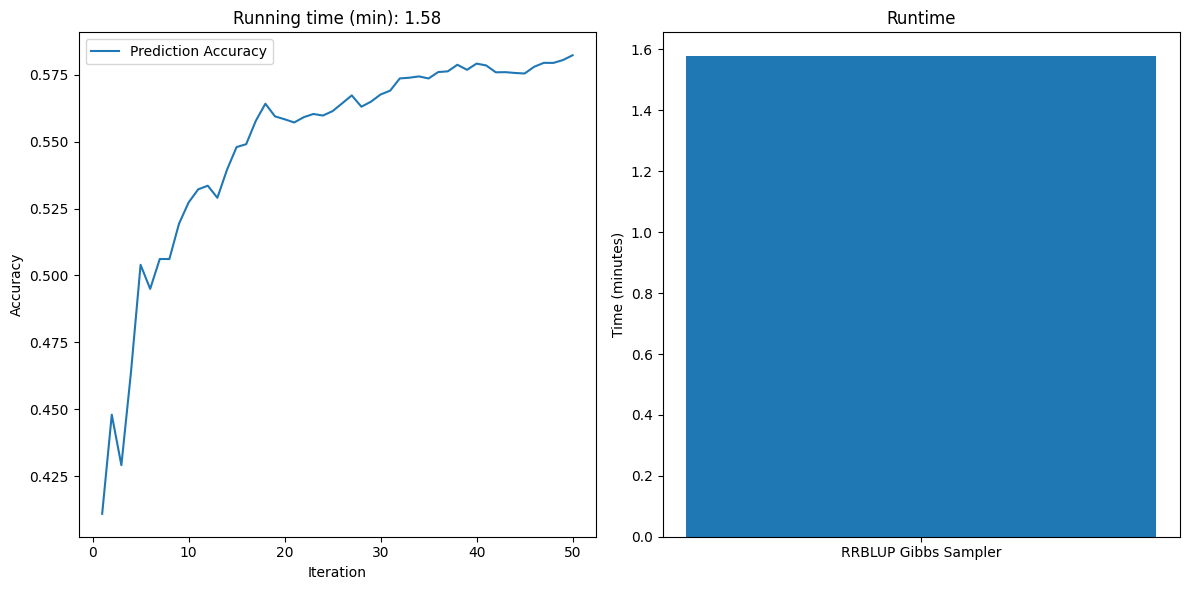

In [5]:
#GPU
import cupy as cp
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import time

device = tch.device("cuda")

def RRBLUP_gibbs_optimized(X, y, σ2_e, σ2_a, nIter):
  p = X.shape[1]  # Number of SNP markers
  a = tch.zeros(p, device=device, dtype=tch.float32)  # Marker effects
  mcmc_a = tch.zeros((nIter, p), device=device, dtype=tch.float32)  # MCMC samples of SNP marker effects

  XTX = tch.matmul(X.T, X)  # X'X
  XT_y = tch.matmul(X.T, y)  # X'y for use in solving for a

  λ = σ2_e / σ2_a
  diag_lambda = λ.expand(p)  # Used for adding λ to the diagonal of XTX for ridge regression solution
  lhs = XTX + tch.diag(diag_lambda)  # Left-hand side of the equation for solving a

  for iter in range(nIter):
      var_a = σ2_e / tch.diag(lhs)  # Variance of a
      mean_a = (XT_y - tch.matmul(XTX, a)) / diag_lambda  # Mean of a
      a = mean_a + tch.randn(p, device=device, dtype=tch.float32) * tch.sqrt(var_a)  # Updated marker effects
      mcmc_a[iter, :] = a

  return mcmc_a

def pearson_correlation_pytorch(x, y):
  mean_x = tch.mean(x)
  mean_y = tch.mean(y)
  xm = x - mean_x
  ym = y - mean_y
  r_num = tch.sum(xm * ym)
  r_den = tch.sqrt(tch.sum(xm ** 2) * tch.sum(ym ** 2))
  r = r_num / r_den
  return r

# Load and preprocess genotype data using Pandas
geno_df = pd.read_csv("geno_n3534_p10000.txt", delimiter=',', header=None)
geno_data = tch.tensor(geno_df.values, device=device, dtype=tch.float32)
X = geno_data
X -= tch.mean(X, dim=0)
Xtrain = X[:3000, :]
Xtest = X[3000:, :]

# Load phenotype data
y_df = pd.read_csv("y.h2.0.3.qtlpct.0.1.rep.1.csv")
y = tch.tensor(y_df['y'].values, dtype=tch.float32, device=device)
bv = tch.tensor(y_df['bv'].values, dtype=tch.float32, device=device)
ytrain = y[:3000]
bv_test = bv[3000:]

# Set experiment parameters
qtl_pct = 0.1
h2 = 0.3
n_qtl = int(X.shape[1] * qtl_pct)
σ2_e = tch.tensor(1 - h2, dtype=tch.float32, device=device)
σ2_a = tch.tensor(h2 / n_qtl, dtype=tch.float32, device=device)
nIter = 50

# Set random seed for reproducibility
tch.manual_seed(123)

# Measure runtime of the RRBLUP Gibbs sampler
start_time = time.time()
mcmc_a = RRBLUP_gibbs(Xtrain, ytrain, σ2_e, σ2_a, nIter)
end_time = time.time()
time_diff = (end_time - start_time) / 60  # Convert seconds to minutes

# Calculate runtime in minutes
runtime_minutes = (end_time - start_time) / 60

# Initialize array for prediction accuracy
accuracy_gibbs = tch.zeros(nIter, device=device, dtype=tch.float32)

# Calculate prediction accuracy
for i in range(nIter):
    pos_mean_a = tch.mean(mcmc_a[:i+1, :], dim=0)
    ebv = tch.matmul(Xtest, pos_mean_a.unsqueeze(-1)).squeeze(-1)
    if tch.unique(ebv).numel() > 1 and tch.unique(bv_test).numel() > 1:
        accuracy_gibbs[i] = pearson_correlation_pytorch(ebv, bv_test)
    else:
        accuracy_gibbs[i] = tch.tensor(float('nan'), device=device, dtype=tch.float32)

# Plotting accuracy over iterations
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, nIter + 1), accuracy_gibbs.cpu().numpy(), label="Prediction Accuracy")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.title(f"Running time (min): {runtime_minutes:.2f}")
plt.legend()

# Displaying runtime
plt.subplot(1, 2, 2)
plt.bar('RRBLUP Gibbs Sampler', runtime_minutes)
plt.ylabel('Time (minutes)')
plt.title('Runtime')

plt.tight_layout()
plt.show()


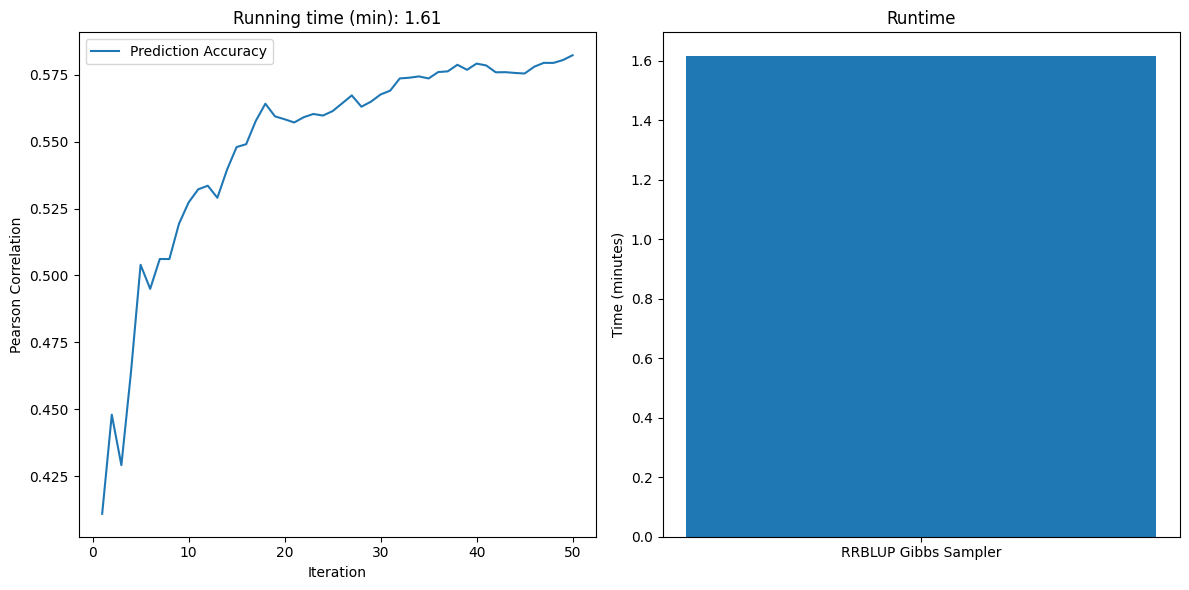

In [4]:
#GPU
import torch as tch
import pandas as pd
import matplotlib.pyplot as plt
import time

# Ensure PyTorch uses CUDA if available
device = tch.device("cuda")

def RRBLUP_gibbs(X, y, σ2_e, σ2_a, nIter):
    p = X.shape[1]  # Number of SNP markers
    a = tch.zeros(p, device=device, dtype=tch.float32)  # Marker effects
    mcmc_a = tch.zeros((nIter, p), device=device, dtype=tch.float32)  # MCMC samples of SNP marker effects
    ycorr = y - tch.matmul(X, a)  # y corrected for all markers
    # λ = σ2_e / σ2_a
    XTX = tch.matmul(X.T, X)  # Precompute X'X

    for iter in range(nIter):
      λ = σ2_e / σ2_a
      for j in range(p):
          xj = X[:, j]
          ycorr += xj * a[j]  # Adding back the effect of the current marker
          xjtxj = XTX[j, j]
          rhs = tch.dot(xj, ycorr)
          lhs = xjtxj + λ
          var_a_j = σ2_e / lhs
          a[j] = (rhs / lhs) + tch.randn(1, device=device, dtype=tch.float32) * tch.sqrt(var_a_j)
          ycorr -= xj * a[j]  # Subtract the effect of the updated marker
      mcmc_a[iter, :] = a

    return mcmc_a

def pearson_correlation_pytorch(x, y):
    mean_x = tch.mean(x)
    mean_y = tch.mean(y)
    xm = x - mean_x
    ym = y - mean_y
    r_num = tch.sum(xm * ym)
    r_den = tch.sqrt(tch.sum(xm ** 2) * tch.sum(ym ** 2))
    r = r_num / r_den
    return r

# Load and preprocess genotype data using Pandas
geno_df = pd.read_csv("geno_n3534_p10000.txt", delimiter=',', header=None)
geno_data = tch.tensor(geno_df.values, device=device, dtype=tch.float32)
X = geno_data
X -= tch.mean(X, dim=0)
Xtrain = X[:3000, :]
Xtest = X[3000:, :]

# Load phenotype data
y_df = pd.read_csv("y.h2.0.3.qtlpct.0.1.rep.1.csv")
y = tch.tensor(y_df['y'].values, dtype=tch.float32, device=device)
bv = tch.tensor(y_df['bv'].values, dtype=tch.float32, device=device)
ytrain = y[:3000]
bv_test = bv[3000:]

# Set experiment parameters
qtl_pct = 0.1
h2 = 0.3
n_qtl = int(X.shape[1] * qtl_pct)
σ2_e = tch.tensor(1 - h2, dtype=tch.float32, device=device)
σ2_a = tch.tensor(h2 / n_qtl, dtype=tch.float32, device=device)
nIter = 50

# Set random seed for reproducibility
tch.manual_seed(123)

# Measure runtime of the RRBLUP Gibbs sampler
start_time = time.time()
mcmc_a = RRBLUP_gibbs(Xtrain, ytrain, σ2_e, σ2_a, nIter)
end_time = time.time()
time_diff = (end_time - start_time) / 60  # Convert seconds to minutes

# Calculate runtime in minutes
runtime_minutes = (end_time - start_time) / 60

# Initialize array for prediction accuracy
accuracy_gibbs = tch.zeros(nIter, device=device, dtype=tch.float32)

# Calculate prediction accuracy
for i in range(nIter):
    pos_mean_a = tch.mean(mcmc_a[:i+1, :], dim=0)
    ebv = tch.matmul(Xtest, pos_mean_a.unsqueeze(-1)).squeeze(-1)
    if tch.unique(ebv).numel() > 1 and tch.unique(bv_test).numel() > 1:
        accuracy_gibbs[i] = pearson_correlation_pytorch(ebv, bv_test)
    else:
        accuracy_gibbs[i] = tch.tensor(float('nan'), device=device, dtype=tch.float32)

# Plotting accuracy over iterations
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, nIter + 1), accuracy_gibbs.cpu().numpy(), label="Prediction Accuracy")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.title(f"Running time (min): {runtime_minutes:.2f}")
# plt.title("Prediction Accuracy over Iterations")
plt.legend()

# Displaying runtime
plt.subplot(1, 2, 2)
plt.bar('RRBLUP Gibbs Sampler', runtime_minutes)
plt.ylabel('Time (minutes)')
plt.title('Runtime')

plt.tight_layout()
plt.show()

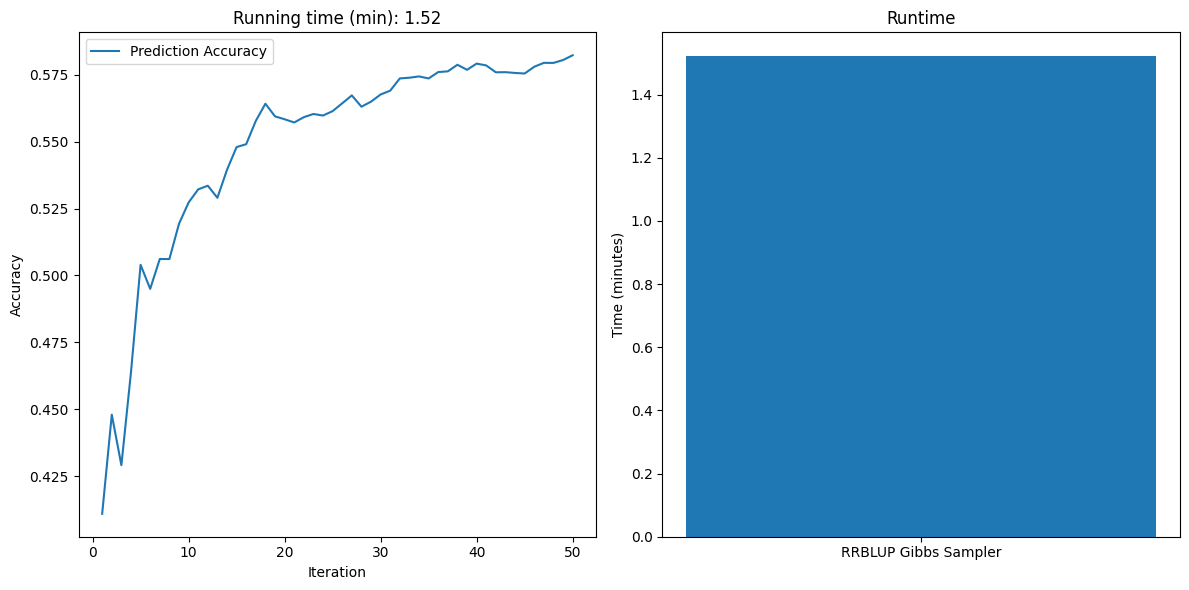

In [15]:
#GPU
import cupy as cp
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import time

device = tch.device("cuda")

def RRBLUP_gibbs_optimized(X, y, σ2_e, σ2_a, nIter):
    p = X.shape[1]  # Number of SNP markers
    a = tch.zeros(p, device=device, dtype=tch.float)  # Marker effects
    mcmc_a = tch.zeros((nIter, p), device=device, dtype=tch.float)  # MCMC samples of SNP marker effects

    # Pre-compute X'X and X'y, which are constant
    XTX = tch.matmul(X.T, X)
    XT_y = tch.matmul(X.T, y)

    λ = σ2_e / σ2_a
    Iλ = tch.eye(p, device=device, dtype=tch.float) * λ  # λ multiplied by the identity matrix for ridge regression
    lhs = XTX + Iλ  # Pre-computing the left-hand side of the solution equation

    # Pre-compute the inverse of lhs if it's not changing, assuming it's not singular
    lhs_inv = tch.inverse(lhs)

    for iter in range(nIter):
        # Efficient computation of variance and mean for marker effects
        var_a = σ2_e * tch.diag(lhs_inv)
        mean_a = tch.matmul(lhs_inv, XT_y - tch.matmul(XTX, a))
        a = mean_a + tch.randn(p, device=device, dtype=tch.float) * tch.sqrt(var_a)  # Updated marker effects
        mcmc_a[iter, :] = a

    return mcmc_a

def pearson_correlation_pytorch(x, y):
  mean_x = tch.mean(x)
  mean_y = tch.mean(y)
  xm = x - mean_x
  ym = y - mean_y
  r_num = tch.sum(xm * ym)
  r_den = tch.sqrt(tch.sum(xm ** 2) * tch.sum(ym ** 2))
  r = r_num / r_den
  return r

# Load and preprocess genotype data using Pandas
geno_df = pd.read_csv("geno_n3534_p10000.txt", delimiter=',', header=None)
geno_data = tch.tensor(geno_df.values, device=device, dtype=tch.float)
X = geno_data
X -= tch.mean(X, dim=0)
Xtrain = X[:3000, :]
Xtest = X[3000:, :]

# Load phenotype data
y_df = pd.read_csv("y.h2.0.3.qtlpct.0.1.rep.1.csv")
y = tch.tensor(y_df['y'].values, dtype=tch.float, device=device)
bv = tch.tensor(y_df['bv'].values, dtype=tch.float, device=device)
ytrain = y[:3000]
bv_test = bv[3000:]

# Set experiment parameters
qtl_pct = 0.1
h2 = 0.3
n_qtl = int(X.shape[1] * qtl_pct)
σ2_e = tch.tensor(1 - h2, dtype=tch.float, device=device)
σ2_a = tch.tensor(h2 / n_qtl, dtype=tch.float, device=device)
nIter = 50

# Set random seed for reproducibility
tch.manual_seed(123)

# Measure runtime of the RRBLUP Gibbs sampler
start_time = time.time()
mcmc_a = RRBLUP_gibbs(Xtrain, ytrain, σ2_e, σ2_a, nIter)
end_time = time.time()
time_diff = (end_time - start_time) / 60  # Convert seconds to minutes

# Calculate runtime in minutes
runtime_minutes = (end_time - start_time) / 60

# Initialize array for prediction accuracy
accuracy_gibbs = tch.zeros(nIter, device=device, dtype=tch.float)

# Calculate prediction accuracy
for i in range(nIter):
    pos_mean_a = tch.mean(mcmc_a[:i+1, :], dim=0)
    ebv = tch.matmul(Xtest, pos_mean_a.unsqueeze(-1)).squeeze(-1)
    accuracy_gibbs[i] = pearson_correlation_pytorch(ebv, bv_test)


# Plotting accuracy over iterations
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, nIter + 1), accuracy_gibbs.cpu().numpy(), label="Prediction Accuracy")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.title(f"Running time (min): {runtime_minutes:.2f}")
plt.legend()

# Displaying runtime
plt.subplot(1, 2, 2)
plt.bar('RRBLUP Gibbs Sampler', runtime_minutes)
plt.ylabel('Time (minutes)')
plt.title('Runtime')

plt.tight_layout()
plt.show()


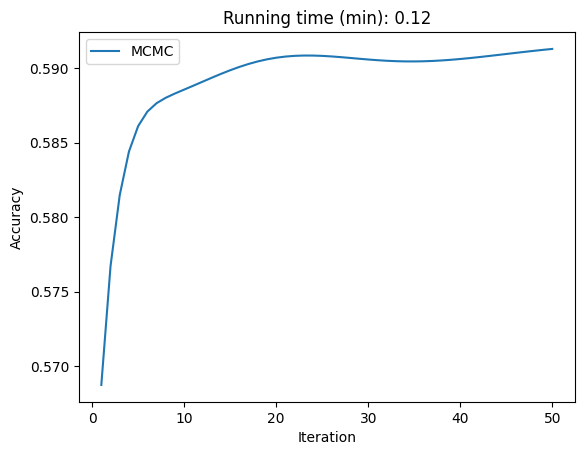

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import time

def RRBLUP_gibbs_optimized(X, y, σ2_e, σ2_a, nIter):
    p = X.shape[1]  # Number of SNP markers
    a = np.zeros(p, dtype=np.float32)  # Marker effects
    mcmc_a = np.zeros((nIter, p), dtype=np.float32)  # MCMC samples of SNP marker effects

    XTX = np.dot(X.T, X)  # Precompute X'X
    XT_y = np.dot(X.T, y)  # Precompute X'y

    λ = σ2_e / σ2_a
    λI = λ * np.eye(p)  # Create λ times identity matrix only once

    for iter in range(nIter):
        for j in range(p):
            xj = X[:, j]
            XTy_j = XT_y[j] - np.dot(XTX[j, :], a) + XTX[j, j] * a[j]
            a[j] = (XTy_j) / (XTX[j, j] + λ)

        mcmc_a[iter, :] = a

    return mcmc_a

# Load genotype data
X = np.loadtxt("geno_n3534_p10000.txt", delimiter=',').astype(np.float32)
X = X - np.mean(X, axis=0)
Xtrain = X[:3000, :]
Xtest = X[3000:, :]
n, p = X.shape

# Load phenotype data
y_df = pd.read_csv("y.h2.0.3.qtlpct.0.1.rep.1.csv")
y = y_df['y'].values.astype(np.float32)
bv = y_df['bv'].values.astype(np.float32)
ytrain = y[:3000]
bv_test = bv[3000:]

# Set experiment parameters
qtl_pct = 0.1
h2 = 0.3
n_qtl = int(p * qtl_pct)
σ2_e = np.float32(1 - h2)
σ2_a = np.float32(h2 / n_qtl)
nIter = 50

# Set random seed for reproducibility
np.random.seed(123)

# Run the RRBLUP Gibbs sampler
start_time = time.time()
mcmc_a = RRBLUP_gibbs_optimized(Xtrain, ytrain, σ2_e, σ2_a, nIter)
end_time = time.time()
time_diff = (end_time - start_time) / 60  # Convert seconds to minutes

# Initialize array for prediction accuracy
accuracy_gibbs = np.zeros(nIter, dtype=np.float32)

# Calculate prediction accuracy
for i in range(nIter):
    pos_mean_a = np.mean(mcmc_a[:i+1, :], axis=0)
    ebv = np.dot(Xtest, pos_mean_a)
    if len(np.unique(ebv)) > 1 and len(np.unique(bv_test)) > 1:
        accuracy_gibbs[i] = pearsonr(ebv, bv_test)[0]
    else:
        accuracy_gibbs[i] = np.nan

# Plot the prediction accuracy over iterations
plt.plot(range(1, nIter + 1), accuracy_gibbs, label="MCMC")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.title(f"Running time (min): {time_diff:.2f}")
plt.legend()
plt.show()


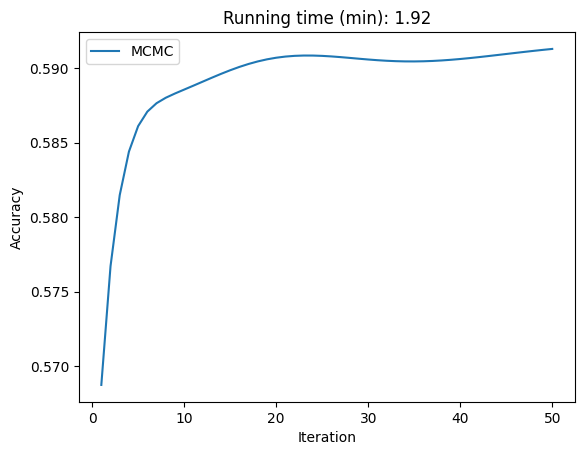

In [13]:
#GPU
import cupy as cp
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import time

def RRBLUP_gibbs_optimized_gpu(X, y, σ2_e, σ2_a, nIter):
  p = X.shape[1]  # Number of SNP markers
  a = cp.zeros(p, dtype=cp.float32)  # Marker effects
  mcmc_a = cp.zeros((nIter, p), dtype=cp.float32)  # MCMC samples of SNP marker effects

  XTX = cp.dot(X.T, X)  # Precompute X'X
  XT_y = cp.dot(X.T, y)  # Precompute X'y

  λ = σ2_e / σ2_a
  λI = λ * cp.eye(p)  # Create λ times identity matrix only once

  for iter in range(nIter):
      for j in range(p):
          xj = X[:, j]
          XTy_j = XT_y[j] - cp.dot(XTX[j, :], a) + XTX[j, j] * a[j]
          a[j] = (XTy_j) / (XTX[j, j] + λ)

      mcmc_a[iter, :] = a

  return mcmc_a

# Assuming genotype and phenotype data files are available in your environment
# Load genotype data using NumPy for preprocessing
X_np = np.loadtxt("geno_n3534_p10000.txt", delimiter=',').astype(np.float32)
X_np = X_np - np.mean(X_np, axis=0)
Xtrain_np = X_np[:3000, :]
Xtest_np = X_np[3000:, :]
n, p = X_np.shape

# Convert the processed NumPy arrays to CuPy arrays for GPU processing
Xtrain_gpu = cp.asarray(Xtrain_np)
Xtest_gpu = cp.asarray(Xtest_np)

# Load phenotype data using pandas
y_df = pd.read_csv("y.h2.0.3.qtlpct.0.1.rep.1.csv")
y_np = y_df['y'].values.astype(np.float32)
bv = y_df['bv'].values.astype(np.float32)
ytrain_np = y_np[:3000]
bv_test = bv[3000:]

# Convert phenotype data to CuPy arrays
ytrain_gpu = cp.asarray(ytrain_np)

# Set experiment parameters
σ2_e = cp.float32(1 - h2)
σ2_a = cp.float32(h2 / n_qtl)
nIter = 50

# Set random seed for reproducibility
cp.random.seed(123)

# Run the RRBLUP Gibbs sampler on the GPU
start_time = time.time()
mcmc_a_gpu = RRBLUP_gibbs_optimized_gpu(Xtrain_gpu, ytrain_gpu, σ2_e, σ2_a, nIter)
end_time = time.time()
time_diff = (end_time - start_time) / 60  # Time in minutes

# Initialize array for prediction accuracy, compute on GPU, then transfer results for plotting
accuracy_gibbs = cp.zeros(nIter, dtype=cp.float32)
for i in range(nIter):
    pos_mean_a = cp.mean(mcmc_a_gpu[:i+1, :], axis=0)
    ebv_gpu = cp.dot(Xtest_gpu, pos_mean_a)
    ebv_cpu = cp.asnumpy(ebv_gpu)  # Transfer to CPU for compatibility with pearsonr
    accuracy_gibbs[i] = pearsonr(ebv_cpu, bv_test)[0]

# Transfer the accuracy array back to the CPU for plotting
accuracy_gibbs_cpu = cp.asnumpy(accuracy_gibbs)
plt.plot(range(1, nIter + 1), accuracy_gibbs_cpu, label="MCMC")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.title(f"Running time (min): {time_diff:.2f}")
plt.legend()
plt.show()


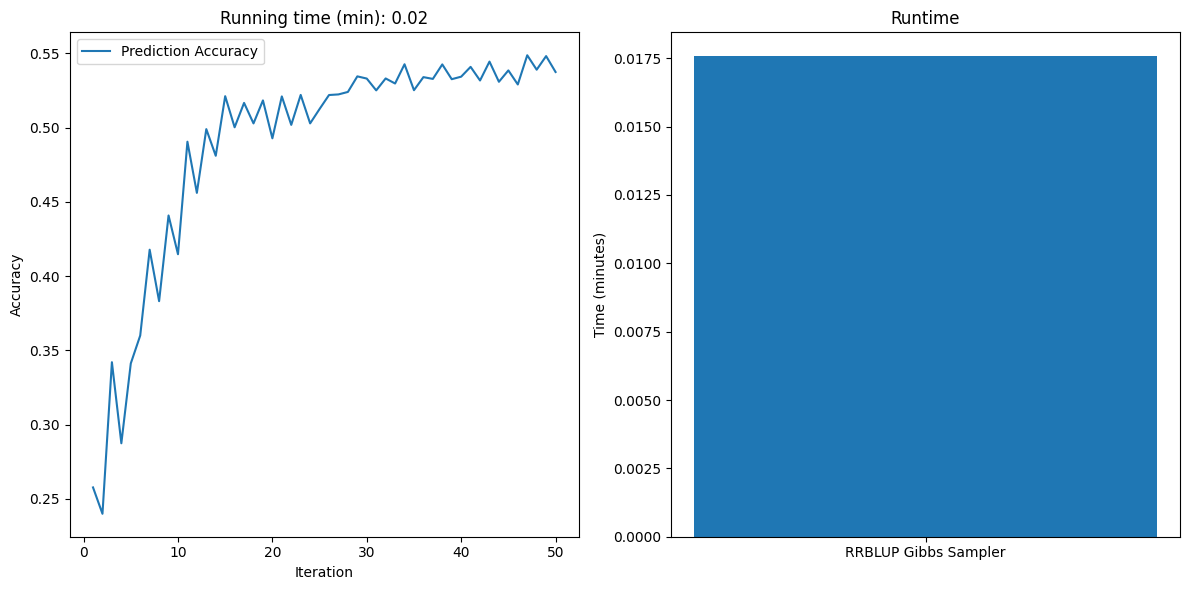

In [18]:
#GPU
import cupy as cp
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import time

device = tch.device("cuda")

def RRBLUP_gibbs_optimized(X, y, σ2_e, σ2_a, nIter):
  p = X.shape[1]  # Number of SNP markers
  a = tch.zeros(p, device=device, dtype=tch.float32)  # Marker effects
  mcmc_a = tch.zeros((nIter, p), device=device, dtype=tch.float32)  # MCMC samples of SNP marker effects

  # Pre-compute X'X and X'y, which are constant
  XTX = tch.matmul(X.T, X)
  XT_y = tch.matmul(X.T, y)

  λ = σ2_e / σ2_a
  Iλ = tch.eye(p, device=device, dtype=tch.float32) * λ  # λ multiplied by the identity matrix for ridge regression
  lhs = XTX + Iλ  # Pre-computing the left-hand side of the solution equation

  # Pre-compute the inverse of lhs if it's not changing, assuming it's not singular
  lhs_inv = tch.inverse(lhs)

  for iter in range(nIter):
    # Efficient computation of variance and mean for marker effects
    var_a = σ2_e * tch.diag(lhs_inv)
    mean_a = tch.matmul(lhs_inv, XT_y - tch.matmul(XTX, a))
    a = mean_a + tch.randn(p, device=device, dtype=tch.float32) * tch.sqrt(var_a)  # Updated marker effects
    mcmc_a[iter, :] = a

  return mcmc_a


def pearson_correlation_pytorch(x, y):
  mean_x = tch.mean(x)
  mean_y = tch.mean(y)
  xm = x - mean_x
  ym = y - mean_y
  r_num = tch.sum(xm * ym)
  r_den = tch.sqrt(tch.sum(xm ** 2) * tch.sum(ym ** 2))
  r = r_num / r_den
  return r

# Load and preprocess genotype data using Pandas
geno_df = pd.read_csv("geno_n3534_p10000.txt", delimiter=',', header=None)
geno_data = tch.tensor(geno_df.values, device=device, dtype=tch.float32)
X = geno_data
X -= tch.mean(X, dim=0)
Xtrain = X[:3000, :]
Xtest = X[3000:, :]

# Load phenotype data
y_df = pd.read_csv("y.h2.0.3.qtlpct.0.1.rep.1.csv")
y = tch.tensor(y_df['y'].values, dtype=tch.float32, device=device)
bv = tch.tensor(y_df['bv'].values, dtype=tch.float32, device=device)
ytrain = y[:3000]
bv_test = bv[3000:]

# Set experiment parameters
qtl_pct = 0.1
h2 = 0.3
n_qtl = int(X.shape[1] * qtl_pct)
σ2_e = tch.tensor(1 - h2, dtype=tch.float32, device=device)
σ2_a = tch.tensor(h2 / n_qtl, dtype=tch.float32, device=device)
nIter = 50

# Set random seed for reproducibility
tch.manual_seed(123)

# Measure runtime of the RRBLUP Gibbs sampler
start_time = time.time()
mcmc_a = RRBLUP_gibbs_optimized(Xtrain, ytrain, σ2_e, σ2_a, nIter)
end_time = time.time()
time_diff = (end_time - start_time) / 60  # Convert seconds to minutes

# Calculate runtime in minutes
runtime_minutes = (end_time - start_time) / 60

# Initialize array for prediction accuracy
accuracy_gibbs = tch.zeros(nIter, device=device, dtype=tch.float32)

# Calculate prediction accuracy
for i in range(nIter):
    pos_mean_a = tch.mean(mcmc_a[:i+1, :], dim=0)
    ebv = tch.matmul(Xtest, pos_mean_a.unsqueeze(-1)).squeeze(-1)
    accuracy_gibbs[i] = pearson_correlation_pytorch(ebv, bv_test)


# Plotting accuracy over iterations
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, nIter + 1), accuracy_gibbs.cpu().numpy(), label="Prediction Accuracy")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.title(f"Running time (min): {runtime_minutes:.2f}")
plt.legend()

# Displaying runtime
plt.subplot(1, 2, 2)
plt.bar('RRBLUP Gibbs Sampler', runtime_minutes)
plt.ylabel('Time (minutes)')
plt.title('Runtime')

plt.tight_layout()
plt.show()